In [ ]:
#@title foo
#!pip install transformers==4.1.1 plotnine

## setting stuff up

In [1]:
import re
import itertools

import numpy as np
import pandas as pd

from IPython.display import HTML
import seaborn
import plotnine
from plotnine import *

from ahviz import create_indices, create_dataframe, filter_mask
import torch
from transformers import AutoModel, AutoTokenizer

plotnine.options.figure_size = (20, 20)

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [5]:
# uncomment to force CPU if you have a GPU but not enough memory to do what you want. it will be slow of course

device = torch.device("cpu")

In [6]:
#transformer = "distilbert-base-cased"
transformer = "bert-base-cased"
#transformer = "gpt2"
#transformer = "gpt2-medium"
#transformer = "gpt2-large"
#transformer = "twmkn9/bert-base-uncased-squad2"
tokenizer = AutoTokenizer.from_pretrained(transformer)
model = AutoModel.from_pretrained(transformer, output_attentions=True, output_hidden_states=True)
model.to(device)
model.eval()
model.zero_grad()


## data preparation

Read in the prepared data. Included in the repository is a copy of the penn treebank sample that is included in the `nltk` python package, converted into plain text and split into sentences. But you can replace this with any
text file. Since the first thing we do is join all the text, it isn't even neccessary to split it into sentences.

The script I used to create the file is `convert_corpus.py` in the repository

In [7]:
sentences = pd.read_csv("lines.csv")
concatenated = " ".join(sentences['line'].tolist())
tokens = torch.tensor(tokenizer(concatenated)['input_ids'])

Token indices sequence length is longer than the specified maximum sequence length for this model (111588 > 512). Running this sequence through the model will result in indexing errors


### window size and context

We move a sliding window over the complete dataset so we can always have context around the part we are looking at. This sets up how many tokens the model looks at each step, and with what step size to move through the corpus

- `window_size`:  
    the number of tokens that are in context

- `step`:  
    how many tokens we move ahead in each step through the corpus

- `future`:  
    how many tokens the model can look ahead
    
The mask printed below shows the effect of changing these values. The ones are the tokens we calculate things for, and the zeros are the extra context that the tokens of interest can pay attention to. For models like *GPT2*, `future` should be $0$, as the model only looks back 

In [8]:
window_size = 25
step = 8
future = 8

mask = torch.cat((torch.zeros(window_size - (step + future)), torch.ones(step), torch.zeros(future))).expand((100,-1))[0]

print(mask)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0.,
        0., 0., 0., 0., 0., 0., 0.])


In [9]:
# the model expects every batch to be the same size, so we have to make the input size be a multiple of
# the window_size
pad_len = window_size - (len(tokens) % window_size)
padded = torch.cat((tokens, tokens.new_full((pad_len,), tokenizer.pad_token_id)))

In [10]:
def get_batches(input_tensor:torch.Tensor, size: int, step: int, batch_size :int = 2):
    input_ids = input_tensor.unfold(0, size, step)
    tensor_dataset = torch.utils.data.TensorDataset(input_ids)
    tensor_dataloader = torch.utils.data.DataLoader(tensor_dataset, batch_size=batch_size)
    
    return tensor_dataloader

In [11]:
dl = get_batches(padded, window_size, step, batch_size=50)

In [12]:
# plain distance
#distance_fun = lambda d, w: d * w
# absolute distance
#distance_func = lambda d, w np.abs(d) * w
# squared distance
distance_func = lambda d, w: np.square(d) * w

In [13]:
data = None
for batch, t in enumerate(dl):
    input_dict = {k: v.to(device) for k, v in zip(["input_ids"], t)}
    
    output = model(**input_dict)

    att = np.array([a.cpu().detach().numpy() for a in output['attentions']])
    
    # swap the 'head' and 'sample' axes so they're in a more natural order
    att = np.swapaxes(att, 1, 2)
#    print(batch, att.shape)
    ix = create_indices(att, sample=batch*att.shape[2])
    df = create_dataframe(att, ix)
    filtered = df[(df['from_token']>(window_size-(step+future))) & (df['from_token']<=(window_size-future)) ].copy()
    filtered['distance'] = (filtered['to_token'] - filtered['from_token'])
    filtered['sign'] = filtered['distance'] > 0
    filtered['weighted'] = distance_func(filtered['distance'], filtered['attention_fraction'])
#    grouped = filtered
    g = filtered.groupby(['layer', 'head', 'sample'])
    grouped = (g['weighted'].agg([np.mean, 'count'])).reset_index()

    if data is None:
        data = grouped
    else:
        data = pd.concat([data, grouped])


## getting the data ready to plot

In [14]:
df = data.reset_index(drop=True)

### calculate the weighted distances and their median per head

In [15]:
display(df)

layer  head  sample      mean  count
0            1     1       1  2.715292    200
1            1     1       2  2.276583    200
2            1     1       3  2.240825    200
3            1     1       4  2.362534    200
4            1     1       5  2.672908    200
...        ...   ...     ...       ...    ...
2008363     12    12   13109  0.447616    200
2008364     12    12   13110  0.193098    200
2008365     12    12   13111  0.246750    200
2008366     12    12   13112  0.286095    200
2008367     12    12   13113  0.239258    200

[2008368 rows x 5 columns]

In [16]:
first_token = window_size - (step + future) + 1

In [17]:
# show the data for the second token of the first sentence for the first layer and the first head
# which is really the first one in the data as I filter out [CLS] above
with pd.option_context("max_rows", None):
    display(df.query(f"layer == 1 & head == 1"))#.sort_values("weighted", ascending=False))

layer  head  sample      mean  count
0            1     1       1  2.715292    200
1            1     1       2  2.276583    200
2            1     1       3  2.240825    200
3            1     1       4  2.362534    200
4            1     1       5  2.672908    200
5            1     1       6  2.378780    200
6            1     1       7  2.364513    200
7            1     1       8  2.313460    200
8            1     1       9  2.647093    200
9            1     1      10  2.193656    200
10           1     1      11  2.166995    200
11           1     1      12  2.418992    200
12           1     1      13  2.508690    200
13           1     1      14  2.717204    200
14           1     1      15  2.358719    200
15           1     1      16  2.568045    200
16           1     1      17  2.262922    200
17           1     1      18  2.014008    200
18           1     1      19  2.778635    200
19           1     1      20  2.300382    200
20           1     1      21  2.205557    200
21           1     1      22  2.303384    200
22           1     1      23  2.064144    200
23           1     1      24  2.606719    200
24           1     1      25  2.324856    200
25           1     1      26  2.417989    200
26           1     1      27  2.730006    200
27           1     1      28  2.425281    200
28           1     1      29  2.720544    200
29           1     1      30  2.486618    200
30           1     1      31  2.524178    200
31           1     1      32  2.633082    200
32           1     1      33  2.256831    200
33           1     1      34  2.676006    200
34           1     1      35  2.787053    200
35           1     1      36  2.484768    200
36           1     1      37  2.223238    200
37           1     1      38  2.085413    200
38           1     1      39  2.455901    200
39           1     1      40  2.212245    200
40           1     1      41  2.414261    200
41           1     1      42  2.379512    200
42           1     1      43  2.381440    200
43           1     1      44  2.357666    200
44           1     1      45  2.671409    200
45           1     1      46  2.411883    200
46           1     1      47  2.378453    200
47           1     1      48  2.802090    200
48           1     1      49  2.378764    200
49           1     1      50  2.216121    200
7200         1     1      51  2.703148    200
7201         1     1      52  2.531836    200
7202         1     1      53  2.671037    200
7203         1     1      54  2.322219    200
7204         1     1      55  2.406418    200
7205         1     1      56  2.558678    200
7206         1     1      57  2.287772    200
7207         1     1      58  2.407107    200
7208         1     1      59  2.516782    200
7209         1     1      60  2.199654    200
7210         1     1      61  2.700387    200
7211         1     1      62  1.941207    200
7212         1     1      63  2.715961    200
7213         1     1      64  2.689096    200
7214         1     1      65  2.360242    200
7215         1     1      66  2.304084    200
7216         1     1      67  2.646575    200
7217         1     1      68  2.227889    200
7218         1     1      69  2.741701    200
7219         1     1      70  2.686615    200
7220         1     1      71  2.575560    200
7221         1     1      72  2.551917    200
7222         1     1      73  2.453571    200
7223         1     1      74  2.219409    200
7224         1     1      75  2.363848    200
7225         1     1      76  2.565431    200
7226         1     1      77  2.393622    200
7227         1     1      78  1.995638    200
7228         1     1      79  2.491410    200
7229         1     1      80  2.491760    200
7230         1     1      81  2.296748    200
7231         1     1      82  2.462194    200
7232         1     1      83  2.314023    200
7233         1     1      84  2.256490    200
7234         1     1      85  2.780234    200
7235         1     1      86  2.314728    200
7236   

In [18]:
g = df.groupby(['layer', 'head'])
median_dist = (g['mean'].mean()).reset_index().round(3)

In [19]:
with pd.option_context('max_rows', 10000):
    display(median_dist)

layer  head   mean
0        1     1  2.442
1        1     2  0.840
2        1     3  1.982
3        1     4  0.195
4        1     5  2.003
5        1     6  1.601
6        1     7  1.279
7        1     8  2.583
8        1     9  1.910
9        1    10  2.223
10       1    11  2.762
11       1    12  2.109
12       2     1  2.487
13       2     2  0.942
14       2     3  1.757
15       2     4  1.488
16       2     5  0.355
17       2     6  2.613
18       2     7  2.808
19       2     8  1.074
20       2     9  3.390
21       2    10  2.009
22       2    11  3.105
23       2    12  0.065
24       3     1  3.041
25       3     2  2.335
26       3     3  2.315
27       3     4  0.040
28       3     5  1.770
29       3     6  2.510
30       3     7  2.569
31       3     8  2.942
32       3     9  2.483
33       3    10  2.583
34       3    11  2.257
35       3    12  2.622
36       4     1  3.051
37       4     2  2.479
38       4     3  2.836
39       4     4  2.229
40       4     5  1.002
41       4     6  2.062
42       4     7  2.510
43       4     8  1.280
44       4     9  2.082
45       4    10  1.673
46       4    11  1.712
47       4    12  0.147
48       5     1  3.083
49       5     2  2.162
50       5     3  0.616
51       5     4  1.740
52       5     5  2.202
53       5     6  1.032
54       5     7  2.779
55       5     8  2.131
56       5     9  1.549
57       5    10  1.700
58       5    11  2.251
59       5    12  2.643
60       6     1  2.095
61       6     2  0.145
62       6     3  1.742
63       6     4  1.658
64       6     5  0.977
65       6     6  2.198
66       6     7  1.250
67       6     8  0.933
68       6     9  0.735
69       6    10  1.103
70       6    11  1.469
71       6    12  1.629
72       7     1  2.536
73       7     2  0.154
74       7     3  0.918
75       7     4  0.619
76       7     5  1.069
77       7     6  0.777
78       7     7  1.970
79       7     8  0.654
80       7     9  0.828
81       7    10  0.096
82       7    11  0.432
83       7    12  1.326
84       8     1  0.578
85       8     2  0.575
86       8     3  0.833
87       8     4  1.380
88       8     5  0.547
89       8     6  1.730
90       8     7  1.342
91       8     8  1.912
92       8     9  0.820
93       8    10  1.519
94       8    11  1.018
95       8    12  1.172
96       9     1  0.651
97       9     2  1.069
98       9     3  3.589
99       9     4  1.014
100      9     5  1.036
101      9     6  3.017
102      9     7  1.533
103      9     8  2.128
104      9     9  1.412
105      9    10  0.640
106      9    11  1.122
107      9    12  2.166
108     10     1  1.468
109     10     2  0.585
110     10     3  1.558
111     10     4  1.817
112     10     5  1.291
113     10     6  1.675
114     10     7  1.845
115     10     8  1.163
116     10     9  1.413
117     10    10  1.630
118     10    11  1.771
119     10    12  1.018
120     11     1  2.554
121     11     2  2.082
122     11     3  0.954
123     11     4  0.563
124     11     5  1.087
125     11     6  1.489
126     11     7  1.069
127     11     8  1.538
128     11     9  1.790
129     11    10  1.188
130     11    11  3.584
131     11    12  2.528
132     12     1  2.231
133     12     2  1.761
134     12     3  1.014
135     12     4  0.574
136     12     5  1.673
137     12     6  1.907
138     12     7  1.716
139     12     8  2.004
140     12     9  1.794
141     12    10  1.783
142     12    11  1.967
143     12    12  0.542

## plot

<AxesSubplot:xlabel='head', ylabel='layer'>

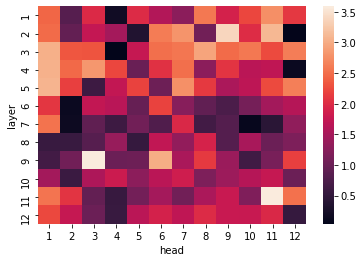

In [22]:
seaborn.heatmap(median_dist.pivot("layer", "head", "mean"))

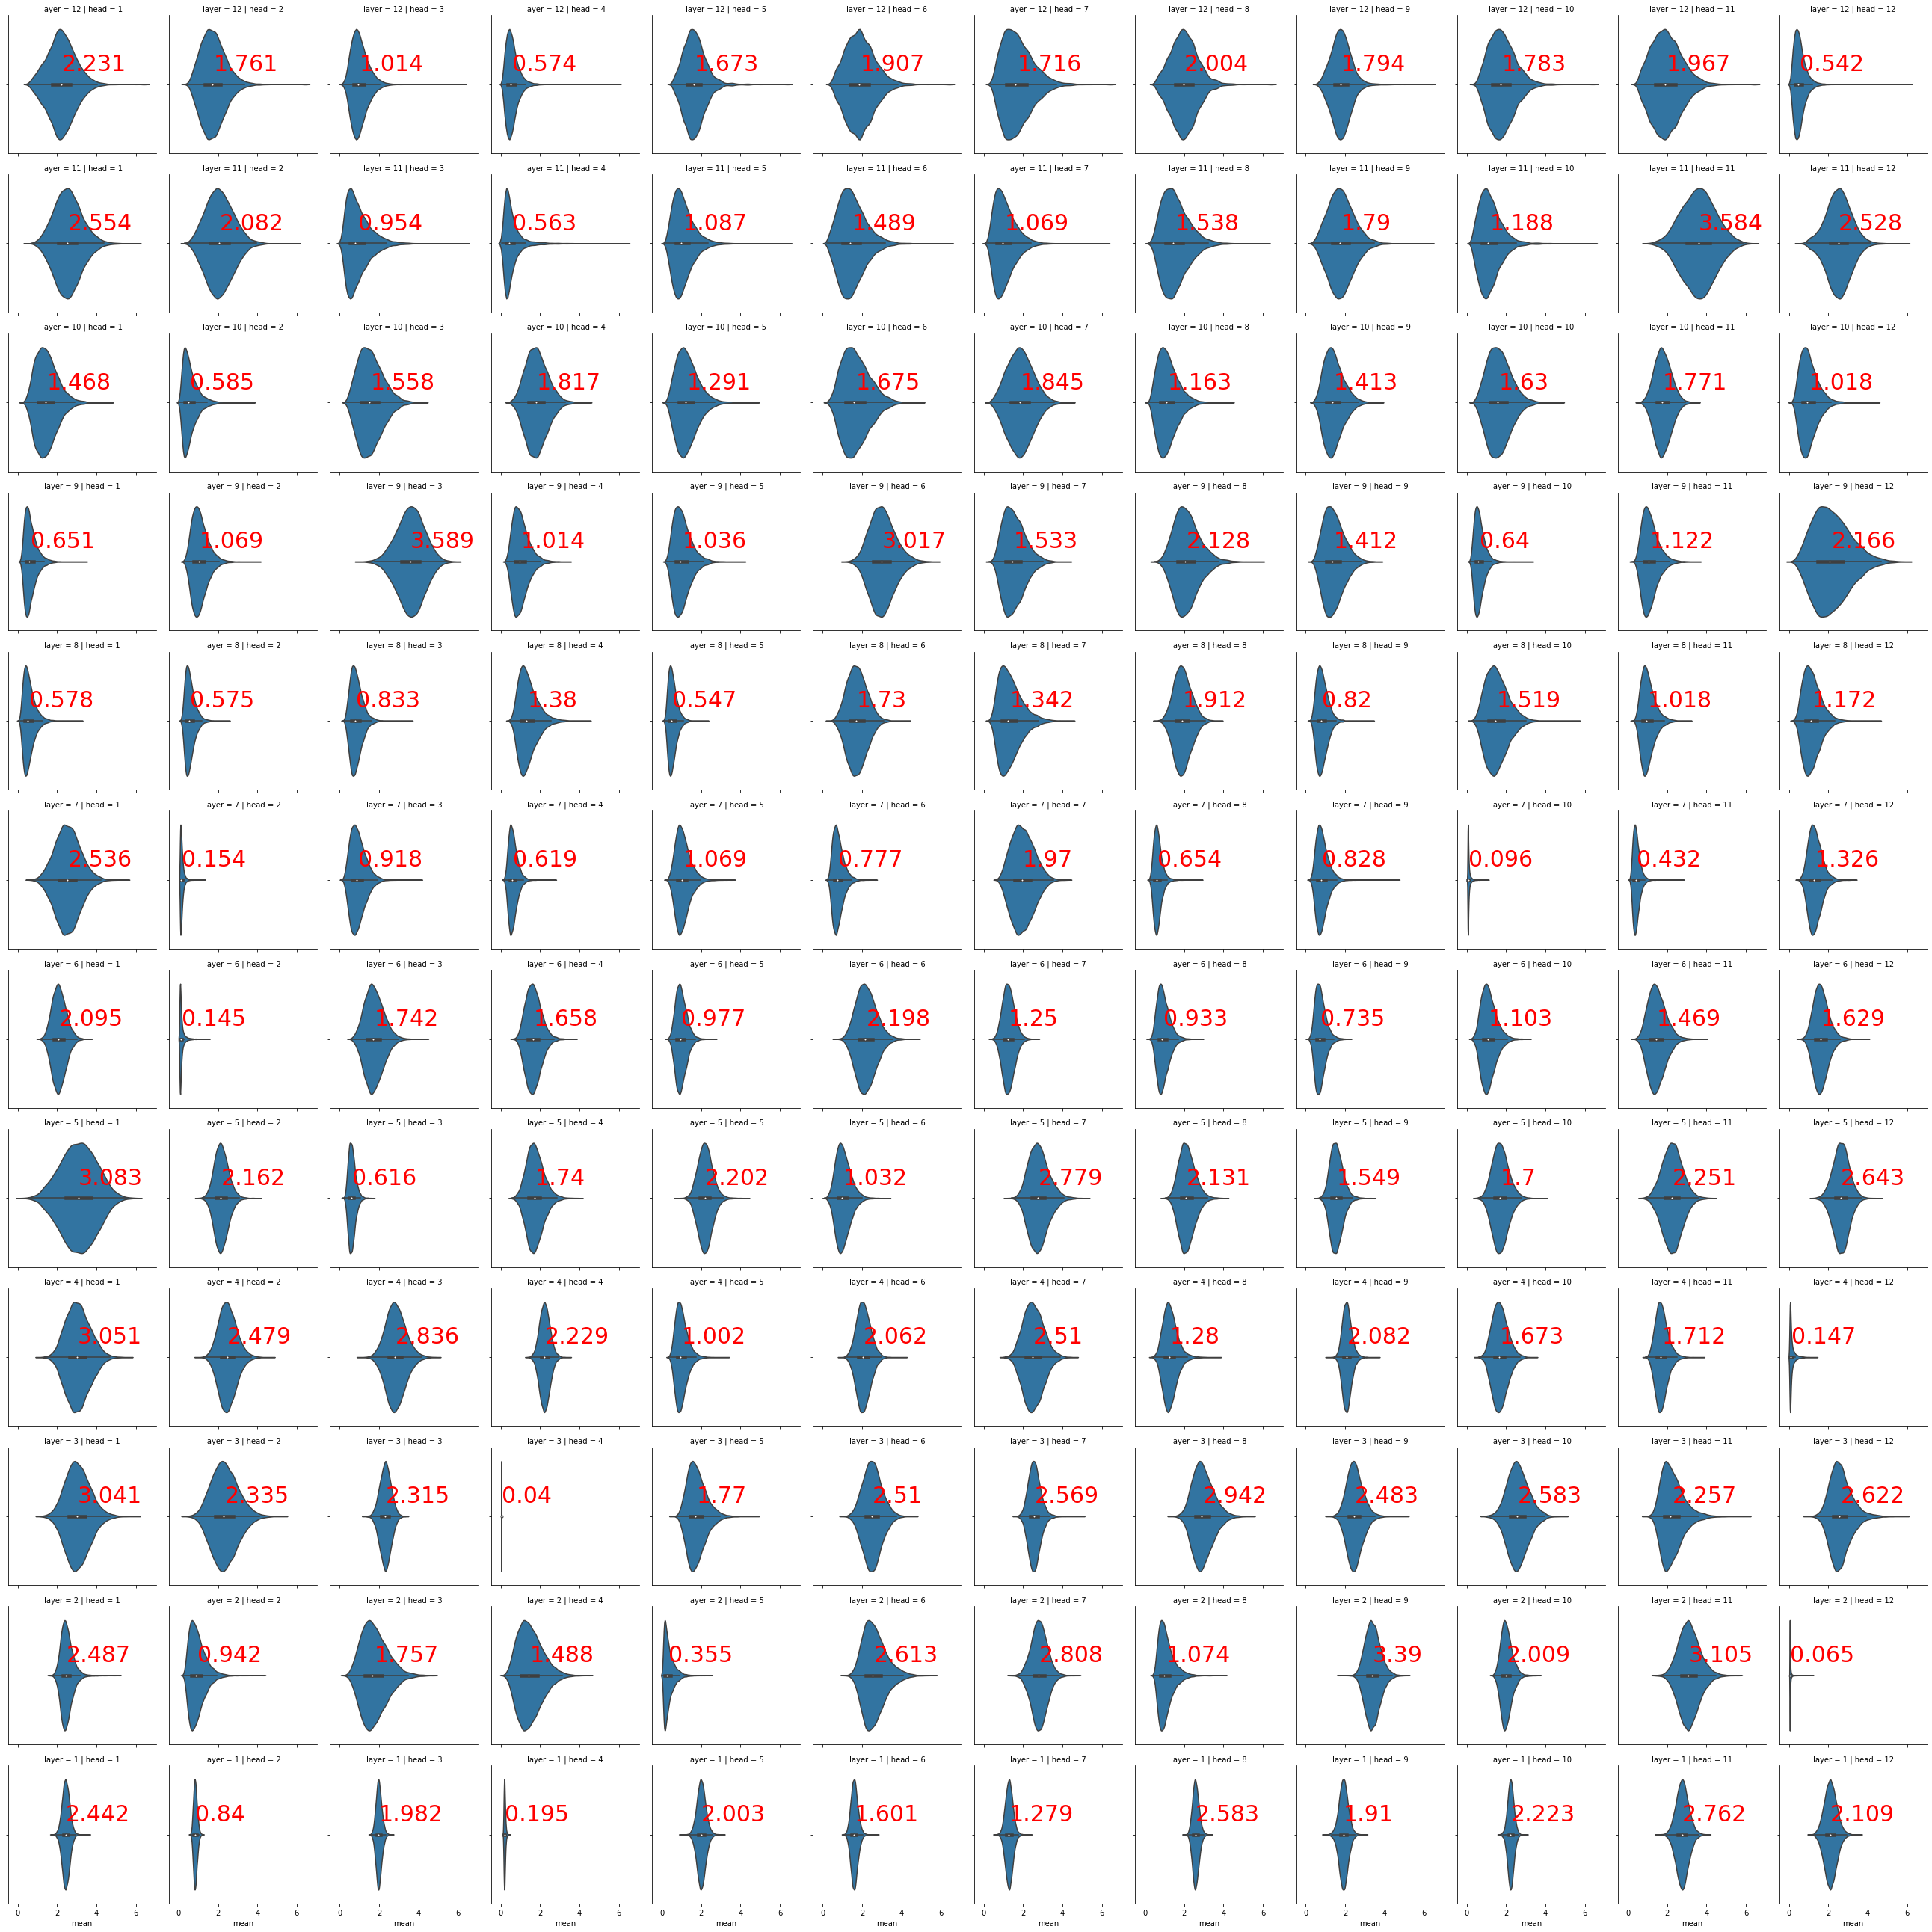

In [20]:
l = h = 12
def make_violin(x, **kwargs):
    v = seaborn.violinplot(x=x, **kwargs)
    data = kwargs['data']
    median_k = np.median(data[x])
    mean = np.mean(data[x]).round(3)
    v.text(mean, -0.1, str(mean), fontdict=dict(color="red", fontsize=30))
    return v
g = seaborn.FacetGrid(df, col="head",  row="layer", col_order=(np.arange(h) + 1), row_order=np.flip(np.arange(l) + 1))
g.map_dataframe(make_violin, "mean")

### subset of heads

plot only a few heads, so each facet can be bigger and it's not as neccesary to limit what is shown